Performing OPTICS clustering grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Program Files\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [ 0.  0.  0.  0.  0.  0. nan nan nan  0.  0.  0.  0.  0.  0. nan nan nan
  0.  0.  0.  0.  0.  0. nan nan nan  0.  0.  0.  0.  0.  0. nan nan nan]
  warnings.warn(


Best parameters: {'optics__cluster_method': 'xi', 'optics__max_eps': 5.0, 'optics__min_samples': 5, 'optics__xi': 0.05}
Best score: 0.0

Cluster sizes:
-1    93
 0     6
Name: count, dtype: int64


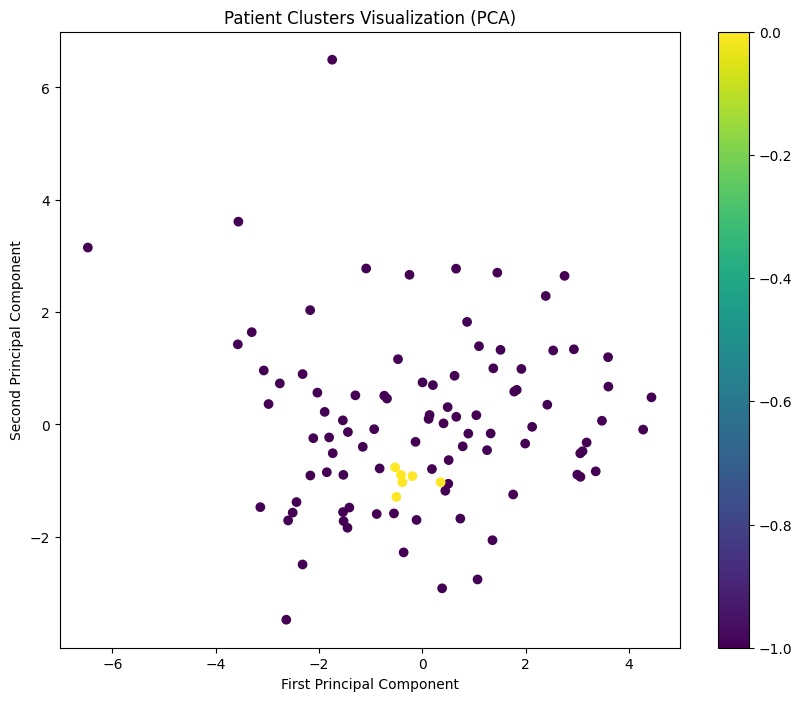

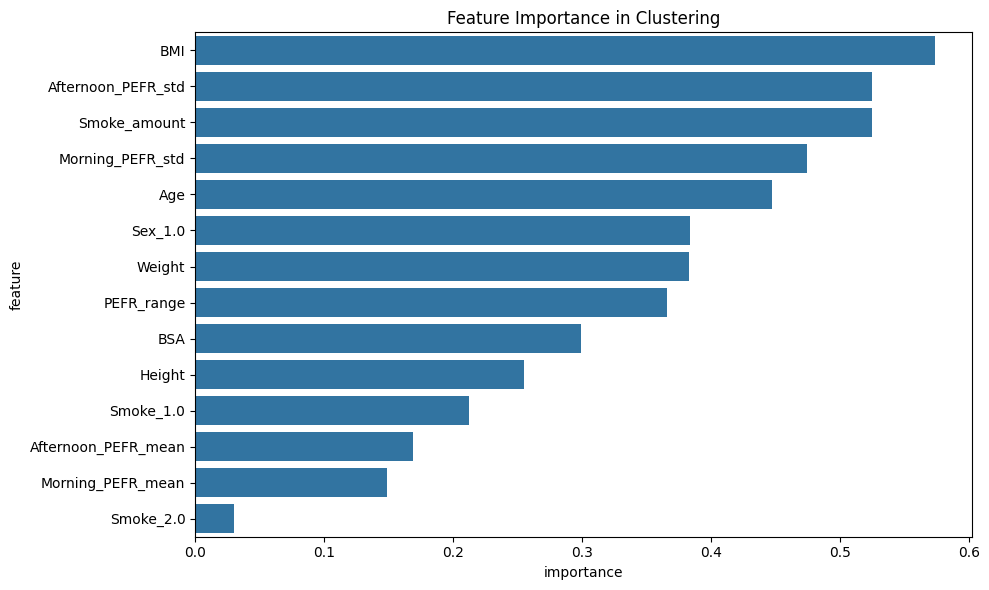


Cluster 0 characteristics:
Age: mean = 4.18, std = 0.13
Smoke_amount: mean = 0.00, std = 0.00
Height: mean = 5.09, std = 0.01
Weight: mean = 4.06, std = 0.02
BMI: mean = 3.12, std = 0.04
BSA: mean = 0.96, std = 0.01
Morning_PEFR_mean: mean = 5.89, std = 0.07
Morning_PEFR_std: mean = 0.07, std = 0.02
Afternoon_PEFR_mean: mean = 5.89, std = 0.07
Afternoon_PEFR_std: mean = 0.06, std = 0.02
PEFR_range: mean = 0.00, std = 0.00
Sex:
Sex
1.0    1.0
Name: proportion, dtype: float64
Smoke:
Smoke
0.0    1.0
Name: proportion, dtype: float64
----------------------------------------
Results saved to optics_cluster_labels.npy and optics_feature_importance.csv


In [1]:
# Version 1
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import OPTICS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        df["Date"] = pd.to_datetime(df["Date"])
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


# Function to extract time series features
def extract_time_series_features(group):
    return pd.Series(
        {
            "Age": group["Age"].iloc[0],
            "Sex": group["Sex"].iloc[0],
            "Smoke": group["Smoke"].iloc[0],
            "Smoke_amount": group["Smoke_amount"].iloc[0],
            "Height": group["Height"].iloc[0],
            "Weight": group["Weight"].iloc[0],
            "BMI": group["BMI"].iloc[0],
            "BSA": group["BSA"].iloc[0],
            "Morning_PEFR_mean": group["Morning_PEFR"].mean(),
            "Morning_PEFR_std": group["Morning_PEFR"].std(),
            "Afternoon_PEFR_mean": group["Afternoon_PEFR"].mean(),
            "Afternoon_PEFR_std": group["Afternoon_PEFR"].std(),
            "PEFR_range": (group["Afternoon_PEFR"] - group["Morning_PEFR"]).mean(),
        }
    )


# Preprocess the data
def preprocess_data(df):
    # Convert categorical columns to numeric
    df["Sex"] = df["Sex"].map({"M": 0, "F": 1})
    df["Smoke"] = df["Smoke"].map({"NS": 0, "ES": 1, "SM": 2})

    # Apply log transformation to handle potential extreme values
    numeric_cols = [
        "Age",
        "Smoke_amount",
        "Height",
        "Weight",
        "BMI",
        "BSA",
        "Morning_PEFR",
        "Afternoon_PEFR",
    ]
    for col in numeric_cols:
        df[col] = np.log1p(df[col])

    return df.groupby("ID").apply(extract_time_series_features).reset_index()


# Define features for clustering
numeric_features = [
    "Age",
    "Smoke_amount",
    "Height",
    "Weight",
    "BMI",
    "BSA",
    "Morning_PEFR_mean",
    "Morning_PEFR_std",
    "Afternoon_PEFR_mean",
    "Afternoon_PEFR_std",
    "PEFR_range",
]
categorical_features = ["Sex", "Smoke"]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features),
    ],
    force_int_remainder_cols=False,
)

# Create OPTICS clustering pipeline
optics_pipeline = Pipeline([("preprocessor", preprocessor), ("optics", OPTICS())])


# Define a comprehensive scoring function
def clustering_score(estimator, X):
    labels = estimator.fit_predict(X)
    n_clusters = len(np.unique(labels[labels != -1]))  # Exclude noise points

    if n_clusters <= 1:
        return 0  # Return 0 for single cluster or no clusters

    preprocessed_X = estimator.named_steps["preprocessor"].transform(X)

    try:
        sil_score = silhouette_score(preprocessed_X, labels)
        ch_score = calinski_harabasz_score(preprocessed_X, labels)
        return (0.7 * sil_score) + (0.3 * ch_score)
    except Exception as e:
        print(f"Error in clustering_score: {e}")
        return 0


# Define parameter grid for OPTICS
param_grid = {
    "optics__min_samples": [5, 10, 20],
    "optics__max_eps": [5.0, 10.0],
    "optics__cluster_method": ["xi", "dbscan"],
    "optics__xi": [0.05, 0.1, 0.2],
}


# Perform grid search
def perform_grid_search(optics_pipeline, param_grid, X):
    grid_search = GridSearchCV(
        optics_pipeline,
        param_grid=param_grid,
        scoring=clustering_score,
        cv=5,
        n_jobs=-1,
        verbose=2,
    )
    grid_search.fit(X)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    return grid_search, grid_search.best_estimator_


# Visualize clusters using PCA
def visualize_clusters(X, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap="viridis")
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.show()


# Analyze feature importance
def analyze_feature_importance(feature_names, X, labels):
    importances = []
    for feature in range(X.shape[1]):
        f_importances = []
        for cluster in np.unique(labels):
            if cluster != -1:  # Exclude noise points
                cluster_points = X[labels == cluster]
                if len(cluster_points) > 1:  # Avoid issues with very small clusters
                    f_importances.append(
                        np.mean(
                            np.abs(cluster_points[:, feature] - np.mean(X[:, feature]))
                        )
                    )
        importances.append(np.mean(f_importances) if f_importances else 0)

    feature_importance = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    )
    feature_importance = feature_importance.sort_values("importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_importance)
    plt.title("Feature Importance in Clustering")
    plt.tight_layout()
    plt.show()

    return feature_importance


# Print cluster characteristics
def print_cluster_characteristics(df, labels):
    df_with_clusters = df.copy()
    df_with_clusters["Cluster"] = labels
    for cluster in np.unique(labels):
        if cluster != -1:  # Exclude noise points
            print(f"\nCluster {cluster} characteristics:")
            cluster_data = df_with_clusters[df_with_clusters["Cluster"] == cluster]
            for feature in numeric_features + categorical_features:
                if feature in numeric_features:
                    print(
                        f"{feature}: mean = {cluster_data[feature].mean():.2f}, std = {cluster_data[feature].std():.2f}"
                    )
                else:
                    print(f"{feature}:")
                    print(cluster_data[feature].value_counts(normalize=True))
            print("-" * 40)


# Main function
def main():
    # Load and preprocess data
    df = load_data("2024-Data-Cleaned/merged_patient_data.csv")
    if df is None:
        return

    df_features = preprocess_data(df)

    # Perform grid search
    print("Performing OPTICS clustering grid search...")
    grid_search, best_model = perform_grid_search(
        optics_pipeline, param_grid, df_features
    )

    # Get cluster labels
    cluster_labels = best_model.fit_predict(df_features)

    # Print cluster sizes
    print("\nCluster sizes:")
    print(pd.Series(cluster_labels).value_counts(dropna=False))

    # Visualize clusters
    preprocessed_X = best_model.named_steps["preprocessor"].transform(df_features)
    visualize_clusters(
        preprocessed_X, cluster_labels, "Patient Clusters Visualization (PCA)"
    )

    # Get feature names after preprocessing
    feature_names = (
        numeric_features
        + best_model.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )

    # Analyze feature importance
    feature_importance = analyze_feature_importance(
        feature_names, preprocessed_X, cluster_labels
    )

    # Print cluster characteristics
    print_cluster_characteristics(df_features, cluster_labels)

    # Save results
    np.save("Results/cluster_optics_labels.npy", cluster_labels)
    feature_importance.to_csv(
        "Results/cluster_optics_feature_importance.csv", index=False
    )
    print(
        "Results saved to optics_cluster_labels.npy and optics_feature_importance.csv"
    )


if __name__ == "__main__":
    main()